This noteboook aims to retrieve bitcoin prices minutely, hourly and daily from the [Binance API](https://python-binance.readthedocs.io/en/latest/binance.html) and save results into a csv.

It also gets the Google Trends data hourly from [pytrends](https://pypi.org/project/pytrends/#api) open-source library (unofficial library for Google Trends API)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import math
import os
import config
from datetime import datetime
from dateutil import parser
from datetime import timedelta

from binance.client import Client
from pytrends.request import TrendReq

# Crypto Extraction

In [4]:
### CONSTANTS
symbol = 'BTCUSDT'
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 950
start_time = '1 Jan 2021'

binance_client = Client(api_key=config.API_KEY, api_secret=config.API_SECRET)

In [6]:
### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data):
    """Set a new, old dates for the crypto extraction to retrieve new data."""
    if len(data) > 0:
        old = parser.parse(data["timestamp"].iloc[-1])
    else:
        old = datetime.strptime(start_time, '%d %b %Y')
    new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')

    return old, new


def get_all_binance(symbol, kline_size, save=False):
    """It gets historical btc/usd prices from the binance API
    
    Parameters
    ----------
    symbol : str. Capital letters
    kline_size : str. Period of the prices in return
    save : bool
    """
    filename = 'C:/Users/Javi/Desktop/cryptocurrency_predictor/data/crypto/%s_%s_data.csv' % (symbol, kline_size)

    if os.path.isfile(filename):
        data_df = pd.read_csv(filename)

    else:
        data_df = pd.DataFrame()

    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df)

    delta_min = (newest_point - oldest_point).total_seconds() / 60
    available_data = math.ceil(delta_min / binsizes[kline_size])

    if oldest_point == datetime.strptime(start_time, '%d %b %Y'):
        print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else:
        print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol,
                                                                                                      available_data,
                                                                                                      kline_size))

    klines = binance_client.get_historical_klines(symbol,
                                                  kline_size,
                                                  oldest_point.strftime("%d %b %Y %H:%M:%S"),
                                                  newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines,
                        columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av',
                                 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')

    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else:
        data_df = data

    data_df.set_index('timestamp', inplace=True)
    if save:
        data_df.drop(['quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'], axis=1).to_csv(filename)

    print('All caught up..!')
    # return data_df.drop(['quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'], axis=1)

In [7]:
get_all_binance(symbol=symbol, kline_size='1m', save=True)

All caught up..!


In [8]:
get_all_binance(symbol=symbol, kline_size='5m', save=True)

All caught up..!


In [9]:
get_all_binance(symbol=symbol, kline_size='1h', save=True)

All caught up..!


### First look at the data

In [2]:
btc_h = pd.read_csv('C:/Users/Javi/Desktop/cryptocurrency_predictor/data/crypto/BTCUSDT_1h_data.csv')

In [3]:
btc_h.info()
btc_h.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   1956 non-null   object 
 1   open        1956 non-null   float64
 2   high        1956 non-null   float64
 3   low         1956 non-null   float64
 4   close       1956 non-null   float64
 5   volume      1956 non-null   float64
 6   close_time  1956 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 107.1+ KB


,timestamp,open,high,low,close,volume,close_time
0,2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,2311.811445,1609462799999
1,2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,5403.068471,1609466399999
2,2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,2384.231560,1609469999999
3,2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,1461.345077,1609473599999
4,2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,2038.046803,1609477199999


## Google Trends Extraction

In [2]:
pytrends = TrendReq(hl='en-US', tz=360)
keywords = ['bitcoin']

In [3]:
btc_trends = pytrends.get_historical_interest(keywords,
                                              year_start=2021, month_start=2, day_start=1, hour_start=0,
                                              year_end=2021, month_end=4, day_end=1, hour_end=0,
                                              cat=0, geo='', gprop='', sleep=60
                                             )

As dates are in US CST (UTC - 6) by default, in order to match dates from our twitter extraction data, we need to make the query from 20-02-2021 18:00:00 to 20-03-2021 18:00:00

In [5]:
btc_trends

,bitcoin,isPartial
date,,
2021-02-01 00:00:00,77,False
2021-02-01 01:00:00,73,False
2021-02-01 02:00:00,71,False
2021-02-01 03:00:00,70,False
2021-02-01 04:00:00,73,False
...,...,...
2021-03-31 20:00:00,82,False
2021-03-31 21:00:00,81,False
2021-03-31 22:00:00,75,False


In [6]:
btc_trends.drop('isPartial', axis=1, inplace=True)
# Dates are in US CST (UTC - 6) by default
btc_trends.index = pd.to_datetime(btc_trends.index) + timedelta(hours=6)
btc_trends.info()
btc_trends

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1425 entries, 2021-02-01 06:00:00 to 2021-04-01 06:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   bitcoin  1425 non-null   int32
dtypes: int32(1)
memory usage: 16.7 KB


,bitcoin
date,
2021-02-01 06:00:00,77
2021-02-01 07:00:00,73
2021-02-01 08:00:00,71
2021-02-01 09:00:00,70
2021-02-01 10:00:00,73
...,...
2021-04-01 02:00:00,82
2021-04-01 03:00:00,81
2021-04-01 04:00:00,75


In [13]:
btc_trends = btc_trends[(btc_trends.index >= '2021-02-21') & (btc_trends.index <= '2021-03-22')]

In [15]:
btc_trends.to_csv('C:/Users/Javi/Desktop/cryptocurrency_predictor/data/google_trends/bitcoin_trends.csv')

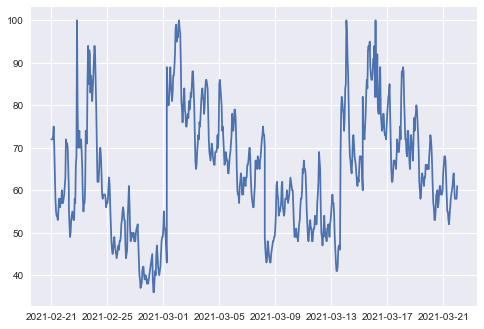

In [14]:
plt.plot(btc_trends['bitcoin'])